Processing maw_VV_Pup_i_240s_2025-02-21T04-12-00.fts
[(array(2521.36935084), array(1857.92173054)), (array(2347.57104203), array(1232.98301848)), (array(2594.59116301), array(1514.05025125)), (array(2778.62467252), array(1361.1709501)), (array(2928.33632137), array(1970.99630534)), (2323.4279766082864, 1719.799252082847)]
Processing maw_VV_Pup_i_240s_2025-02-21T04-27-00.fts
[(array(2528.29456767), array(1850.50457356)), (array(2354.66450962), array(1225.37554188)), (array(2601.63178148), array(1506.49397734)), (array(2785.69890068), array(1353.56998779)), (array(2935.20332059), array(1963.63505137)), (2330.403175863314, 1712.3290147374075)]


Processing maw_VV_Pup_i_240s_2025-02-21T04-42-00.fts
[(array(2538.84990146), array(1840.51117018)), (array(2365.22433741), array(1215.62281271)), (array(2612.1249418), array(1496.65148474)), (array(2796.19106798), array(1343.75256662)), (array(2945.77738302), array(1953.51840643)), (2340.9394194465185, 1702.4266869235012)]


Processing maw_VV_Pup_i_240s_2025-02-21T04-57-00.fts
[(array(2550.33056305), array(1827.44416401)), (array(2376.73906138), array(1202.54243698)), (array(2623.6806062), array(1483.50445713)), (array(2807.75795318), array(1330.57581011)), (array(2957.25117642), array(1940.39229251)), (2352.4300617726803, 1689.3712150356873)]


Processing maw_VV_Pup_i_240s_2025-02-21T05-12-00.fts
[(array(2560.74776684), array(1817.65884162)), (array(2387.17567349), array(1192.55287355)), (array(2634.12406673), array(1473.61629243)), (array(2818.2047356), array(1320.67736112)), (array(2967.65866748), array(1930.74491605)), (2362.871027740984, 1679.4999049758012)]


Processing maw_VV_Pup_i_240s_2025-02-21T05-39-15.fts
[(array(2575.81197803), array(1800.48721157)), (array(2402.37320274), array(1175.44902716)), (array(2649.24204959), array(1456.46699991)), (array(2833.33420307), array(1303.5075187)), (array(2982.6718167), array(1913.49638932)), (2377.980920595839, 1662.3724563595797)]


Processing maw_VV_Pup_i_240s_2025-02-21T06-08-10.fts
[(array(2586.28007633), array(1785.85180843)), (array(2412.69452368), array(1161.00211674)), (array(2659.6197), array(1441.93299939)), (array(2843.67873735), array(1288.99171487)), (array(2993.18406869), array(1898.74608837)), (2388.404408744993, 1647.8171861997037)]


Processing maw_VV_Pup_i_240s_2025-02-21T06-23-10.fts
[(array(2587.26968118), array(1781.05473404)), (array(2413.6607301), array(1156.21890359)), (array(2660.59598791), array(1437.12905592)), (array(2844.65654777), array(1284.17459164)), (array(2994.18903441), array(1893.93216605)), (2389.3854605187357, 1643.0251069536293)]


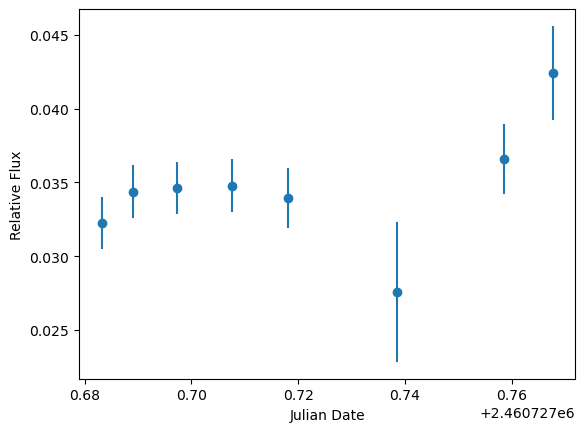

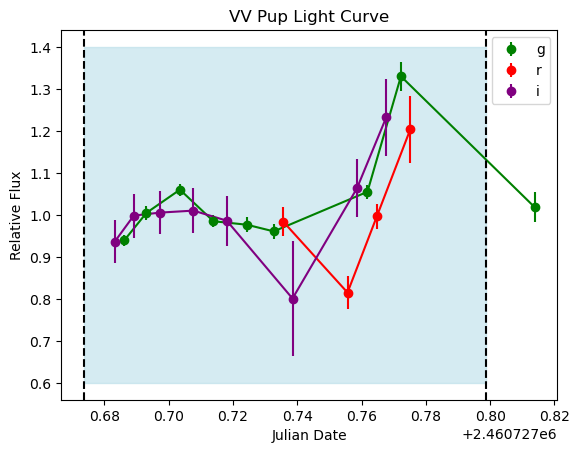

In [6]:
from astropy.stats import sigma_clipped_stats
from astropy.io import fits
from photutils.aperture import ApertureStats, CircularAperture, CircularAnnulus, aperture_photometry
import matplotlib.pyplot as plt
import numpy as np
from astropy.stats import SigmaClip
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
import pandas as pd
import os
import glob
from astropy.time import Time


def make_light_curve(file_dir):
    # Change to the directory containing the images
    os.chdir(file_dir + '/' + filter + '/')

    # Find all FITS files in the directory
    image_files = glob.glob('*.fts')

    # Define the list of star coordinates 
    star_list = [(2524.1591, 1855.3702), (2350.4573, 1230.4712), (2597.4297, 1511.4885), (2781.4578, 1358.5997),(2931.032, 1968.4543)]

    vv_pup = SkyCoord.from_name('VV Pup')
    ra = vv_pup.ra.deg
    dec = vv_pup.dec.deg

    data = fits.getdata(r'E:\MACRO\MCV\MCV Code\VV_Pup_RLMT_Feb_2025\g/maw_VV_Pup_g_240s_2025-02-21T04-21-00.fts')
    header = fits.getheader(r'E:\MACRO\MCV\MCV Code\VV_Pup_RLMT_Feb_2025\g/maw_VV_Pup_g_240s_2025-02-21T04-21-00.fts')

    rdnoise = 6.7
    egain = header['EGAIN']
    gain = 4*egain
        
    wcs = WCS(header)
    star_list_ra_dec = []
    for x, y in star_list:
        star_ra, star_dec = wcs.all_pix2world(x, y, 0)
        star_list_ra_dec = star_list_ra_dec + [(star_ra, star_dec)]

    # Define the aperture and annulus parameters
    aperture_radius = 8  # Radius of the aperture
    annulus_inner_radius = 22  # Inner radius of the annulus
    annulus_outer_radius = 30  # Outer radius of the annulus

    # Initialize a list to store results for all files
    all_results = []

    # Loop over each image file
    for image_file in image_files:
        # Load the FITS data
        data = fits.getdata(image_file)
        header = fits.getheader(image_file)
        print('Processing', image_file)

        wcs = WCS(header)
        xst, yst = wcs.all_world2pix(ra, dec,0)
        star_list = []
        for x, y in star_list_ra_dec:
            x_star, y_star = wcs.all_world2pix(x, y,0)
            star_list = star_list + [(x_star, y_star)]
        xst = float(xst)
        yst = float(yst)
        star_list = star_list + [(xst, yst)]
        print(star_list)

        exptime = header['EXPTIME']
        exptimedays = exptime/(24*3600)
        addjd = exptimedays/2
        
        # Calculate the mean, median, and standard deviation of the data
        mean, median, std = sigma_clipped_stats(data, sigma=3.0)
        
        sigclip = SigmaClip(sigma=3., maxiters=10)

        # Get the Julian Date
        jd = header['JD']
        
        file_results = {'file': image_file, 'Julian_Date': (jd+addjd)}
        
        # Perform aperture photometry for each star
        for i, (x, y) in enumerate(star_list):
            ap = CircularAperture((x, y), r=aperture_radius)
            an = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
            bkg_stats = ApertureStats(data, an, sigma_clip=sigclip)
            ap_stats = ApertureStats(data, ap, local_bkg=bkg_stats.median)
        
            x, y = ap_stats.centroid
            #print(x, y)
        
            aperture = CircularAperture((x, y), r=aperture_radius)
            annulus_aperture = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
            
            # Perform aperture photometry
            phot_table = aperture_photometry(data, aperture)
            bkgstats = ApertureStats(data, annulus_aperture, sigma_clip=sigclip)
            
            # Calculate the background in the annulus
            bkg_mean = bkgstats.mean
            bkg_sum = bkg_mean * aperture.area
            
            bkg_mean_nopedestal = bkg_mean-1000
            bkg_sum_nopedestal = bkg_mean_nopedestal * aperture.area

            
            # Subtract the background from the aperture photometry
            source_sum = phot_table['aperture_sum'][0]*gain - bkg_sum*gain

            # Error calculation (Poisson noise + background noise)
            error = np.sqrt((phot_table['aperture_sum'][0]-1000*aperture.area)*gain + (aperture.area/annulus_aperture.area)**2*bkg_sum_nopedestal*gain + aperture.area*rdnoise**2)
            #error = np.sqrt((phot_table['aperture_sum'][0]-1000*aperture.area) + ((aperture.area)**2/annulus_aperture.area)*bkg_sum_nopedestal + (aperture.area)*rdnoise**2)

            # Turn into a magnitude
            source_mag = -2.5 * np.log10(source_sum / exptime)
            source_mag_err = 1.0857 * error / source_sum

            # Store the results with dynamic column names
            file_results[f'star_{i}_x'] = x
            file_results[f'star_{i}_y'] = y
            file_results[f'star_{i}_flux'] = source_sum
            file_results[f'star_{i}_error'] = error
            file_results[f'star_{i}_background'] = bkg_sum

        # Append the results for this file to the list of all results
        all_results.append(file_results)

    # Convert the results to a DataFrame for easy analysis
    results_df = pd.DataFrame(all_results)

    # Optionally, display the image with the apertures and annuli
    '''for image_file in image_files:
        data = fits.getdata(image_file)
        header = fits.getheader(image_file)
        wcs = WCS(header)

        plt.imshow(data, vmin=median-3*std, vmax=median+3*std, cmap='viridis')
        for (x, y) in star_list:
            aperture = CircularAperture((x, y), r=aperture_radius)
            annulus_aperture = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
            aperture.plot(color='blue', lw=1.5)
            annulus_aperture.plot(color='red', lw=1.5)
        plt.show()'''

    # take the result from the dataframe of star_0_flux and star_1_flux and add together
    results_df['total_flux'] = results_df['star_0_flux'] + results_df['star_1_flux'] + results_df['star_2_flux'] + results_df['star_3_flux'] + results_df['star_4_flux']
    results_df['rel_flux']=results_df['star_5_flux']/results_df['total_flux']

    for i in range(5):
        results_df[f'star_{i}_relflux'] = results_df[f'star_{i}_flux']/results_df['total_flux']

    total_flux_err = np.sqrt(results_df['star_0_error']**2 + results_df['star_1_error']**2 + results_df['star_2_error']**2 + results_df['star_3_error']**2 + results_df['star_4_error']**2)

    #calculate the error on the relative flux
    results_df['star_5_relerror'] = (results_df['star_5_flux']/results_df['total_flux'])*(np.sqrt((results_df['star_5_error']/results_df['star_5_flux'])**2 + (total_flux_err/results_df['total_flux'])**2))

    # Normalize the relative flux
    mean_rel_flux, _, _, = sigma_clipped_stats(results_df['rel_flux'], sigma=  2.0)
    results_df['norm_rel_flux'] = results_df['rel_flux']/mean_rel_flux
    results_df['norm_rel_flux_error'] = results_df['star_5_relerror']/mean_rel_flux
    # Save the results to a CSV file
    results_df.to_csv(r'E:\MACRO\MCV\MCV Code\VV_Pup_RLMT_Feb_2025\Results_' + filter + '.csv', index=False)

    #Plot the relative flux
    #plt.plot(results_df['Julian_Date'], results_df['rel_flux'], 'o')
    plt.errorbar(results_df['Julian_Date'], results_df['rel_flux'], yerr=results_df['star_5_relerror'], fmt='o')
    plt.xlabel('Julian Date')
    plt.ylabel('Relative Flux')
    plt.show()

file_dir = r'E:\MACRO\MCV\MCV Code\VV_Pup_RLMT_Feb_2025'
filter = 'i'



make_light_curve(file_dir)

lc_g = pd.read_csv(r'E:\MACRO\MCV\MCV Code\VV_Pup_RLMT_Feb_2025\Results_g.csv')
lc_r = pd.read_csv(r'E:\MACRO\MCV\MCV Code\VV_Pup_RLMT_Feb_2025\Results_r.csv')
lc_i = pd.read_csv(r'E:\MACRO\MCV\MCV Code\VV_Pup_RLMT_Feb_2025\Results_i.csv')


#sort the dataframes by Julian Date
lc_g = lc_g.sort_values(by=['Julian_Date'])
lc_r = lc_r.sort_values(by=['Julian_Date'])
lc_i = lc_i.sort_values(by=['Julian_Date'])

t_start = Time('2025-02-21T04:10:00', scale='utc')
# Get the Julian Date
jd_start = t_start.jd

t_end = Time('2025-02-21T07:10:00', scale='utc')
jd_end = t_end.jd


plt.errorbar(lc_g['Julian_Date'], lc_g['norm_rel_flux'], yerr=lc_g['norm_rel_flux_error'], fmt='o', label='g', color='green')
plt.plot(lc_g['Julian_Date'], lc_g['norm_rel_flux'], color='green')    
plt.errorbar(lc_r['Julian_Date'], lc_r['norm_rel_flux'], yerr=lc_r['norm_rel_flux_error'], fmt='o', label='r', color='red')
plt.plot(lc_r['Julian_Date'], lc_r['norm_rel_flux'], color='red')
plt.errorbar(lc_i['Julian_Date'], lc_i['norm_rel_flux'], yerr=lc_i['norm_rel_flux_error'], fmt='o', label='i', color='purple')
plt.plot(lc_i['Julian_Date'], lc_i['norm_rel_flux'], color='purple')
plt.axvline(jd_start, color='black', linestyle='--')
plt.axvline(jd_end, color='black', linestyle='--')
# make light blue between the black lines
plt.fill_between([jd_start, jd_end], 0.6, 1.4, color='lightblue', alpha=0.5)

'''plt.scatter(lc_g['Julian_Date'], lc_g['star_0_relflux']/np.mean(lc_g['star_0_relflux']), alpha=0.5, color='gray')
plt.scatter(lc_g['Julian_Date'], lc_g['star_1_relflux']/np.mean(lc_g['star_1_relflux']), alpha=0.5, color='gray')
plt.scatter(lc_g['Julian_Date'], lc_g['star_2_relflux']/np.mean(lc_g['star_2_relflux']), alpha=0.5, color='gray')
plt.scatter(lc_g['Julian_Date'], lc_g['star_3_relflux']/np.mean(lc_g['star_3_relflux']), alpha=0.5, color='gray')
plt.scatter(lc_g['Julian_Date'], lc_g['star_4_relflux']/np.mean(lc_g['star_4_relflux']), alpha=0.5, color='gray')
plt.scatter(lc_i['Julian_Date'], lc_i['star_0_relflux']/np.mean(lc_i['star_0_relflux']), alpha=0.5, color='gray')
plt.scatter(lc_i['Julian_Date'], lc_i['star_1_relflux']/np.mean(lc_i['star_1_relflux']), alpha=0.5, color='gray')
plt.scatter(lc_i['Julian_Date'], lc_i['star_2_relflux']/np.mean(lc_i['star_2_relflux']), alpha=0.5, color='gray')
plt.scatter(lc_i['Julian_Date'], lc_i['star_3_relflux']/np.mean(lc_i['star_3_relflux']), alpha=0.5, color='gray')
plt.scatter(lc_i['Julian_Date'], lc_i['star_4_relflux']/np.mean(lc_i['star_4_relflux']), alpha=0.5, color='gray')
plt.scatter(lc_r['Julian_Date'], lc_r['star_0_relflux']/np.mean(lc_r['star_0_relflux']), alpha=0.5, color='gray')
plt.scatter(lc_r['Julian_Date'], lc_r['star_1_relflux']/np.mean(lc_r['star_1_relflux']), alpha=0.5, color='gray')
plt.scatter(lc_r['Julian_Date'], lc_r['star_2_relflux']/np.mean(lc_r['star_2_relflux']), alpha=0.5, color='gray')
plt.scatter(lc_r['Julian_Date'], lc_r['star_3_relflux']/np.mean(lc_r['star_3_relflux']), alpha=0.5, color='gray')
plt.scatter(lc_r['Julian_Date'], lc_r['star_4_relflux']/np.mean(lc_r['star_4_relflux']), alpha=0.5, color='gray')'''



plt.title('VV Pup Light Curve')
plt.xlabel('Julian Date')
plt.ylabel('Relative Flux')
plt.legend()
plt.show()